# squeeze-and-excitation Network (SENet)

CNN 모델의 경우 입력데이터의 공간 정보와 그들간의 복잡한 상관 관계는 channel 특징에 학습이 된다.

왜냐하면 CNN은 가중치 필터 단위로 독립적으로 학습하며 이를 통해 데이터 내의 정보를 얻기 떄문이다.

하지만 CNN 만으로는 서로 다른 필터 간의 관련성을 파악하기 어렵다. (가중치 필터는 서로 독립이기 때문이다.)

SENet은 필터들의 특징 파악하여 보다 효과적으로 채널 특징을 재구성 위한 목적으로 고안되었다.

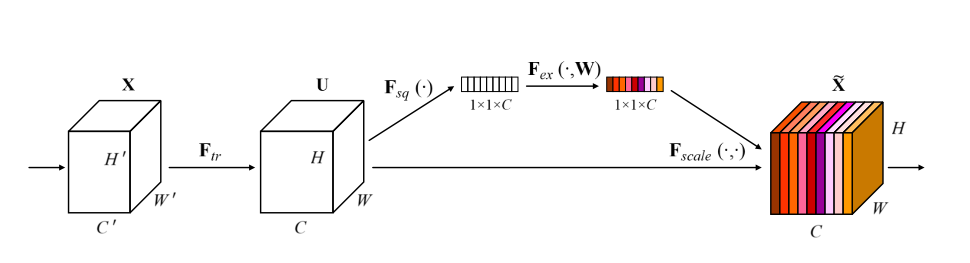

# 1. Squeeze 파트

channel 특징을 대표하는 값을 학습하기 위한 신경망 구조로 다음 2단계가 존재한다.
- global average pooling : 각 채널의 대표값을 얻기 위해 공간(2d) 축에 대해 풀링을 계산 (C,H,W) -> (C)


In [51]:
import torch.nn.functional as F
from torch import nn
import torch

class Squeeze(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch, channel_size, h, w = x.size()
        x = self.avg_pool(x).view(batch, channel_size)
        return x

#2. Excitation

히든 채널 특징을 바탕으로 각 채널의 중요도를 학습하는 과정

- 1st linear layer : 채널 축의 대표 특징을 학습하기 위해 히든 차원을 줄이는 목적 (C) -> (C')
- 2nd linear layer : 신경망을 통해 원래의 채널 사이즈로 재구성
- sigmoid function : 각 채널의 중요도를 점수화 (0~1)

In [52]:
class excitation(nn.Module):
    def __init__(self, channel, reduction=16):
        super(excitation, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

## 3. 종합하기

In [53]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.squeeze = Squeeze(channel, reduction)
        self.excitation = excitation(channel, reduction)

    def forward(self, x):

        y = self.squeeze(x)
        y = self.excitation(y).view(y.size(0), y.size(1), 1, 1)

        return x * y.expand_as(x)

## 4. Resnet block에 SE layer 추가하기

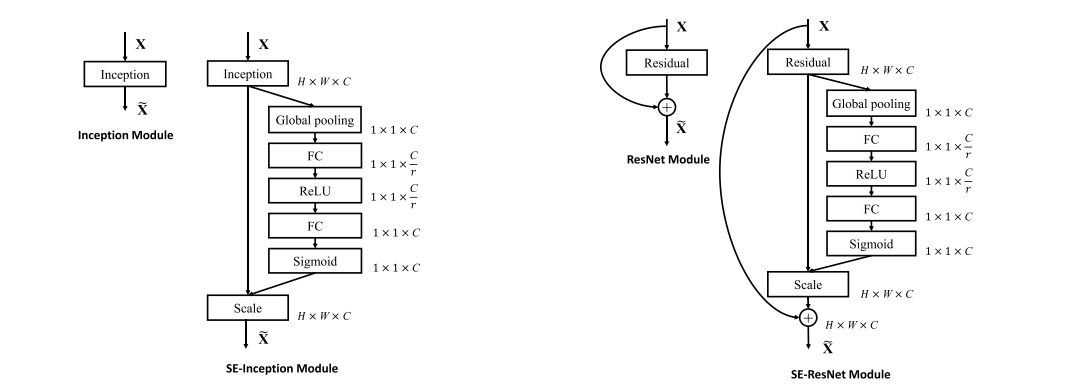

In [54]:
class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(SEBasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False) # 첫번째 convolution
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화 층
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # 두번째 convolution
        self.bn2 = nn.BatchNorm2d(planes)

        self.se = SELayer(planes) # squeeze and excitation

        # skip connection
        self.shortcut = nn.Sequential()
        # 만약 convolution layer로 인해 channel size가 바뀌게 된다면 skip connection 을 위한 convolution layer 를 사용
        # 표 기준으로 layer name이 바뀔때
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)

        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

In [55]:
class SEBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(SEBottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.se = SELayer(planes) # squeeze and excitation

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.se(out)

        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

In [56]:
class SEResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(SEResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out

In [57]:
def seresnet18(**kwargs):
    return SEResNet(SEBasicBlock, [2, 2, 2, 2], **kwargs)

def seresnet34(**kwargs):
    return SEResNet(SEBasicBlock, [3, 4, 6, 3], **kwargs)

def seresnet50(**kwargs):
    return SEResNet(SEBottleneck, [3, 4, 6, 3], **kwargs)

def seresnet101(**kwargs):
    return SEResNet(SEBottleneck, [3, 4, 23, 3], **kwargs)

In [58]:
model_dict = {
    'seresnet18': [seresnet18, 512],
    'seresnet34': [seresnet34, 512],
    'seresnet50': [seresnet50, 2048],
    'seresnet101': [seresnet101, 2048],
}

In [59]:
class SEResNetModel(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128):
        super(SEResNetModel, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SEResNetModel(name='seresnet18', head='mlp', feat_dim=128).to(device)

In [61]:
!pip install torchsummary
from torchsummary import summary

In [62]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,864
       BatchNorm2d-4         [-1, 64, 224, 224]             128
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
           Squeeze-8                   [-1, 64]               0
            Linear-9                    [-1, 4]             256
             ReLU-10                    [-1, 4]               0
           Linear-11                   [-1, 64]             256
          Sigmoid-12                   [-1, 64]               0
       excitation-13                   [-1, 64]               0
          SELayer-14         [-1, 64, 2

In [63]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Epoch [1/10], Train Loss: 3.6358, Val Loss: 3.5426
Epoch [2/10], Train Loss: 3.4992, Val Loss: 3.4698
Epoch [3/10], Train Loss: 3.4375, Val Loss: 3.4093
Epoch [4/10], Train Loss: 3.3943, Val Loss: 3.3680
Epoch [5/10], Train Loss: 3.3702, Val Loss: 3.3500
Epoch [6/10], Train Loss: 3.3495, Val Loss: 3.3443
Epoch [7/10], Train Loss: 3.3338, Val Loss: 3.3304
Epoch [8/10], Train Loss: 3.3213, Val Loss: 3.3187
Epoch [9/10], Train Loss: 3.3127, Val Loss: 3.3138
Epoch [10/10], Train Loss: 3.3026, Val Loss: 3.3057
Test Accuracy: 85.04%


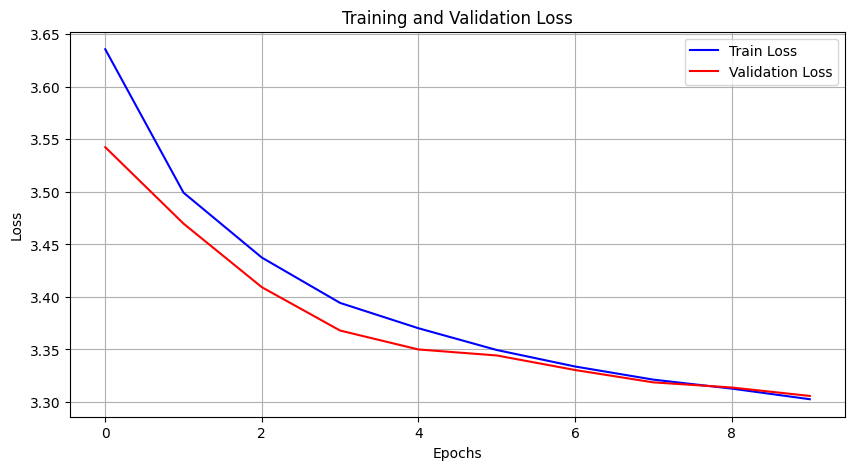

In [64]:
import torchvision
from torchvision import transforms


# data augmentation for image
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# MNIST 데이터 로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train,  download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',  transform=transform_test, train=False)

# 데이터 로더
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# 하이퍼파라미터 설정
feature_dim = 64 # 마지막 은닉층 유닛 수
num_classes = 10 # 물체 이미지 분류
learning_rate = 1e-3

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SEResNetModel(name='seresnet18', head='mlp', feat_dim=feature_dim).to(device)

# 손실 함수와 옵티마이져 설정하기
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 손실 기록 리스트
train_losses = []
val_losses = []

# 학습 루프
num_epochs = 10

# 학습
for epoch in range(num_epochs):
    model.train() # 학습을 알리는 flag
    running_loss = 0.0 # epoch 마다 평균 loss값 측정

    for images, labels in train_loader:
        images = images.to(device) # (batch, 3, 32, 32)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # 검증
    model.eval() # 을 알리는 flag
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) # (batch, 3, 32, 32)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


# 테스트셋을 이용해 모델의 정확도 평가하기
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader: # 테스트 데이터 불러오기
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) # 학습된 모델로부터 테스트 데이터의 예측 값 얻기
        _, predicted = torch.max(outputs.data, 1) # 가장 확률이 높은 숫자 값 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%') # 테스트 데이터셋의 전체 정확도

# 손실값 시각화
plot_losses(train_losses, val_losses)